In [8]:
# ------------------------------------
# 单元格 1: 导入所有库
# ------------------------------------
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Sklearn 库
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 设置 Matplotlib 和 Seaborn 风格
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Source Han Sans SC']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

print("所有库导入成功。")

所有库导入成功。


In [9]:
# ------------------------------------
# 单元格 2: 全局配置
# ------------------------------------
DB_FILE = 'esi_rankings.db'
TABLE_NAME = 'esi_rankings'
TARGET_INSTITUTION = 'EAST CHINA NORMAL UNIVERSITY'

print(f"数据库文件: {DB_FILE}")
print(f"目标机构: {TARGET_INSTITUTION}")

数据库文件: esi_rankings.db
目标机构: EAST CHINA NORMAL UNIVERSITY


In [10]:
# ------------------------------------
# 单元格 3: 共用函数
# ------------------------------------

def load_data(db_file, table_name):
    """
    从 SQLite 数据库加载数据。
    
    :param db_file: 数据库文件名
    :param table_name: 表名
    :return: 包含原始数据的 pandas DataFrame
    """
    print(f"正在从 {db_file} 加载数据...")
    try:
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
        conn.close()
        print(f"数据加载成功，共 {len(df)} 条记录。")
        return df
    except Exception as e:
        print(f"数据加载失败: {e}")
        return pd.DataFrame() # 返回空 DataFrame

def get_aggregated_data(df):
    """
    将原始 DataFrame 按机构聚合，构建高校画像。
    
    :param df: 原始 DataFrame (来自 load_data)
    :return: (df_agg, features) 
             df_agg: 聚合后的 DataFrame
             features: 用于聚合的特征列表
    """
    print("正在按机构聚合数据以构建高校画像...")
    if df.empty:
        print("输入数据为空，无法聚合。")
        return pd.DataFrame(), []
        
    features = [
        'total_subjects', 'avg_rank', 'total_documents', 
        'total_cites', 'total_top_papers', 'avg_cites_per_paper'
    ]
    
    df_agg = df.groupby('institution').agg(
        total_subjects=pd.NamedAgg(column='research_field', aggfunc='count'),
        avg_rank=pd.NamedAgg(column='rank', aggfunc='mean'),
        total_documents=pd.NamedAgg(column='documents', aggfunc='sum'),
        total_cites=pd.NamedAgg(column='cites', aggfunc='sum'),
        total_top_papers=pd.NamedAgg(column='top_papers', aggfunc='sum'),
        avg_cites_per_paper=pd.NamedAgg(column='cites_per_paper', aggfunc='mean') 
    ).reset_index()
    
    print(f"数据聚合完成，共 {len(df_agg)} 所机构。")
    return df_agg, features

print("共用函数 (load_data, get_aggregated_data) 定义完成。")

共用函数 (load_data, get_aggregated_data) 定义完成。


In [11]:
# ------------------------------------
# 单元格 4: 加载原始数据
# ------------------------------------
# 调用单元格 3 中定义的函数
df_raw = load_data(DB_FILE, TABLE_NAME)

# 显示数据样例
if not df_raw.empty:
    print("\n数据预览 (前5行):")
    print(df_raw.head())

正在从 esi_rankings.db 加载数据...
数据加载成功，共 34121 条记录。

数据预览 (前5行):
   id         research_field  rank  \
0   1  AGRICULTURAL SCIENCES     1   
1   2  AGRICULTURAL SCIENCES     2   
2   3  AGRICULTURAL SCIENCES     3   
3   4  AGRICULTURAL SCIENCES     4   
4   5  AGRICULTURAL SCIENCES     5   

                                      institution  country_region  documents  \
0                     CHINESE ACADEMY OF SCIENCES  CHINA MAINLAND      15661   
1        CHINESE ACADEMY OF AGRICULTURAL SCIENCES  CHINA MAINLAND      12222   
2  UNITED STATES DEPARTMENT OF AGRICULTURE (USDA)             USA      12564   
3                   CHINA AGRICULTURAL UNIVERSITY  CHINA MAINLAND      10052   
4                                           INRAE          FRANCE       9314   

    cites  cites_per_paper  top_papers  
0  332254            21.22         251  
1  223855            18.32         198  
2  220644            17.56         105  
3  207779            20.67         166  
4  187838            20.

In [12]:
# ------------------------------------
# 单元格 5: 任务1 - 高校分类与相似高校分析
# ------------------------------------
print("--- 开始执行任务1：高校分类与相似高校分析 ---")

# 1. 分析 (Analysis)
print("\n[分析]: 这是一个聚类 (Clustering) 和 相似性匹配 (Similarity Matching) 问题。")

# 2. 思路 (Approach)
print("[思路]:")
print("  - 调用 get_aggregated_data() 获取机构画像。")
print("  - 使用 StandardScaler 标准化数据 (消除量纲影响)。")
print("  - 使用 K-Means (K=5) 进行聚类分析。")
print("  - 使用标准化后的欧氏距离 (Euclidean Distance) 寻找相似高校。")

# 3. 代码实现 (Code)

# 3.1. 获取聚合数据
df_agg, agg_features = get_aggregated_data(df_raw)

if not df_agg.empty:
    # 3.2. 准备特征并标准化
    df_agg_features = df_agg.set_index('institution')[agg_features].fillna(0)
    
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(df_agg_features)
    df_scaled = pd.DataFrame(features_scaled, index=df_agg_features.index, columns=agg_features)
    print("\n步骤 1/4: 特征标准化完成。")

    # 3.3. K-Means 聚类
    K = 5
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
    df_agg['cluster'] = kmeans.fit_predict(features_scaled)
    print(f"步骤 2/4: K-Means 聚类完成 (K={K})。")

    # 3.4. 分析聚类结果
    cluster_analysis = df_agg.groupby('cluster')[agg_features].mean()
    cluster_analysis['count'] = df_agg['cluster'].value_counts()
    print("\n--- 任务1 结果：全球高校分类 (聚类中心均值) ---")
    print(cluster_analysis)

    # 3.5. 寻找相似高校 (欧氏距离)
    print(f"\n步骤 3/4: 正在寻找与 '{TARGET_INSTITUTION}' 相似的高校...")
    try:
        target_vector_scaled = df_scaled.loc[TARGET_INSTITUTION].values.reshape(1, -1)
        
        distances = euclidean_distances(target_vector_scaled, df_scaled.values)
        df_scaled['distance_to_target'] = distances[0]
        
        df_similar_euclidean = df_scaled.sort_values(by='distance_to_target', ascending=True)
        
        # 提取前11名（包含自己）
        top_similar_euclidean = df_similar_euclidean.iloc[0:11]
        
        # 从 df_agg_features (原始聚合数据) 中提取信息以提高可读性
        original_data_similar = df_agg_features.loc[top_similar_euclidean.index]
        original_data_similar['distance'] = top_similar_euclidean['distance_to_target']
        
        print(f"\n--- 任务1 结果：与 {TARGET_INSTITUTION} 最相似的高校 (欧氏距离) ---")
        print(original_data_similar[['total_subjects', 'avg_rank', 'avg_cites_per_paper', 'distance']])
        print("步骤 4/4: 相似高校分析完成。")

    except KeyError:
        print(f"错误：在数据中未找到机构 '{TARGET_INSTITUTION}'。")
    except Exception as e:
        print(f"计算相似高校时出错: {e}")
else:
    print("聚合数据为空，跳过任务1。")

--- 开始执行任务1：高校分类与相似高校分析 ---

[分析]: 这是一个聚类 (Clustering) 和 相似性匹配 (Similarity Matching) 问题。
[思路]:
  - 调用 get_aggregated_data() 获取机构画像。
  - 使用 StandardScaler 标准化数据 (消除量纲影响)。
  - 使用 K-Means (K=5) 进行聚类分析。
  - 使用标准化后的欧氏距离 (Euclidean Distance) 寻找相似高校。
正在按机构聚合数据以构建高校画像...
数据聚合完成，共 9990 所机构。

步骤 1/4: 特征标准化完成。
步骤 2/4: K-Means 聚类完成 (K=5)。

--- 任务1 结果：全球高校分类 (聚类中心均值) ---
         total_subjects     avg_rank  total_documents   total_cites  \
cluster                                                               
0              2.907097  1519.894761      2490.407903  6.155025e+04   
1             20.763889   163.341380    139027.541667  4.048206e+06   
2              1.033791  4887.824182       216.190426  7.974747e+03   
3             15.757866   587.575101     32236.870041  8.163620e+05   
4              1.000000  4919.506849         1.493151  7.956890e+03   

         total_top_papers  avg_cites_per_paper  count  
cluster                                                
0               52.783710    

--- 开始执行任务2：华东师范大学学科画像 ---

[分析]: 这是一个探索性数据分析 (EDA) 问题。
[思路]:
  - 从 df_raw 筛选出华师大所有记录。
  - 从 广度 (学科数)、高度 (排名)、影响力 (Top Papers)、质量 (篇均引) 四个角度分析。
  - 使用 Seaborn 条形图 (barplot) 进行可视化。

步骤 1/4: 筛选 'EAST CHINA NORMAL UNIVERSITY' 数据...
步骤 2/4: 学科广度分析完成。共 17 个学科进入 ESI 前 1%。
步骤 3/4: 学科排名、高被引、篇均引数据排序完成。

--- 任务2 结果：学科画像详情 ---
优势学科 (排名前3): 
            research_field  rank
3119             CHEMISTRY    90
22230          MATHEMATICS   115
16247  ENVIRONMENT/ECOLOGY   130

影响力学科 (Top Papers 前3): 
            research_field  top_papers
3119             CHEMISTRY         157
16247  ENVIRONMENT/ECOLOGY         101
13647          ENGINEERING          86

高质量学科 (篇均引用 前3): 
                     research_field  cites_per_paper
24180  MOLECULAR BIOLOGY & GENETICS            38.66
20731             MATERIALS SCIENCE            34.55
16247           ENVIRONMENT/ECOLOGY            31.31

步骤 4/4: 正在生成可视化图表...


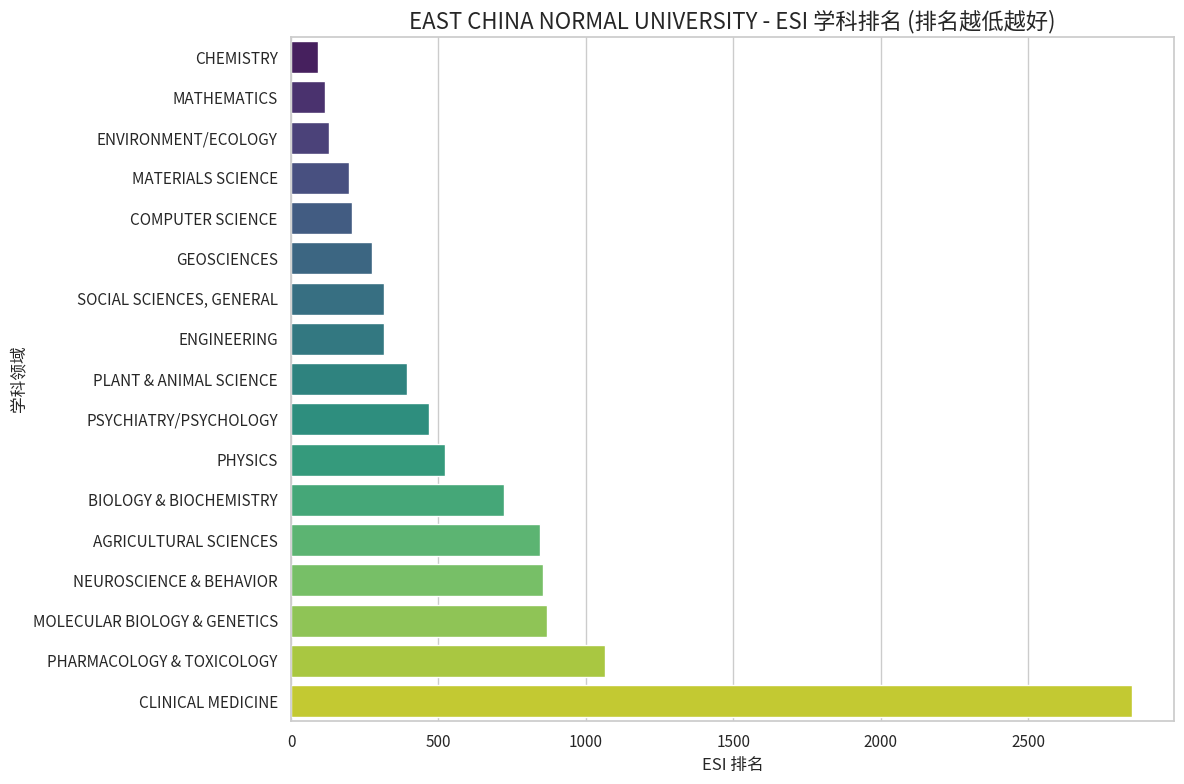

  - 已生成学科排名图: ecnu_subject_rankings.png


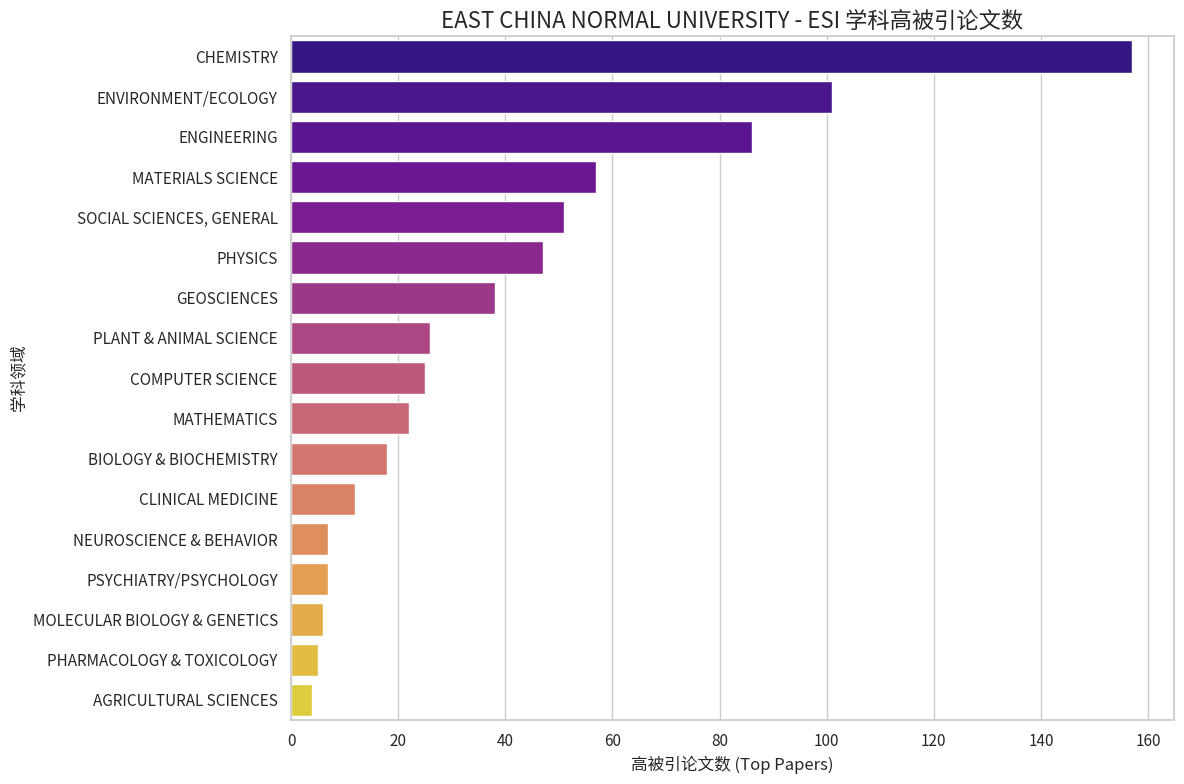

  - 已生成高被引论文图: ecnu_top_papers.png


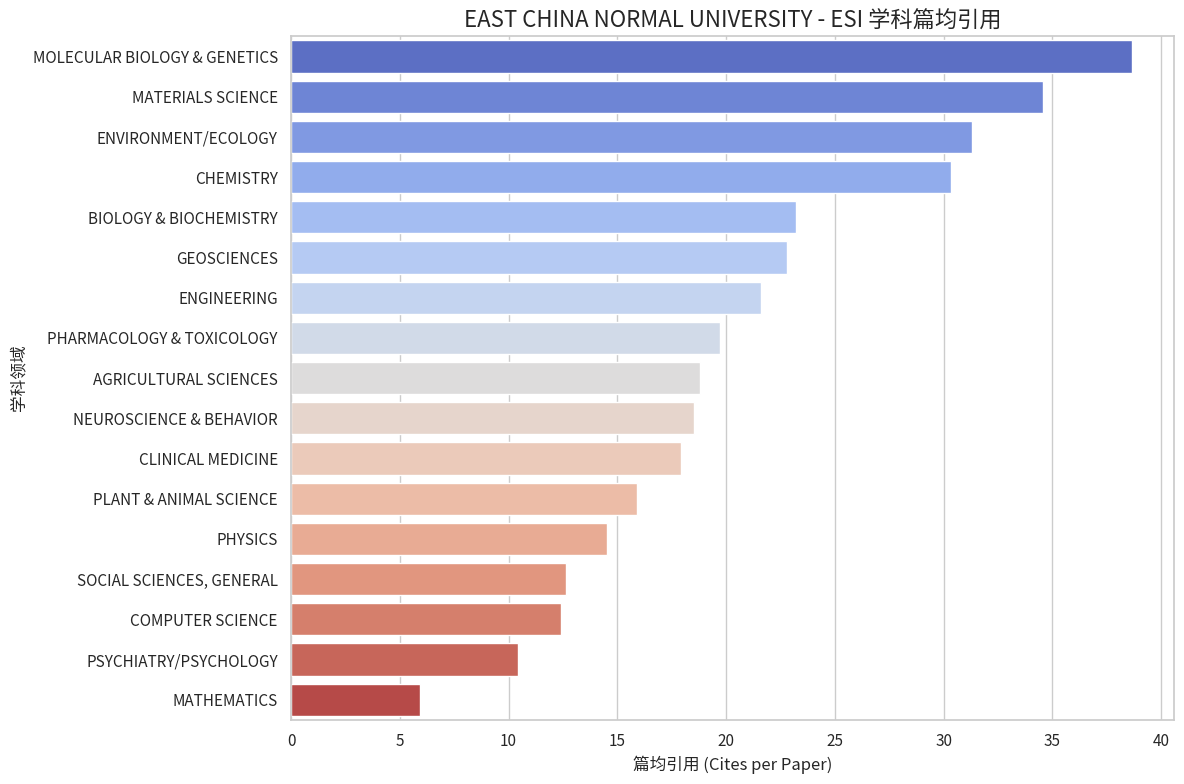

  - 已生成篇均引用图: ecnu_cites_per_paper.png

--- 任务2 完成 ---


In [13]:
# ------------------------------------
# 单元格 6: 任务2 - 华东师范大学学科画像 (EDA)
# ------------------------------------
print("--- 开始执行任务2：华东师范大学学科画像 ---")

# 1. 分析 (Analysis)
print("\n[分析]: 这是一个探索性数据分析 (EDA) 问题。")

# 2. 思路 (Approach)
print("[思路]:")
print("  - 从 df_raw 筛选出华师大所有记录。")
print("  - 从 广度 (学科数)、高度 (排名)、影响力 (Top Papers)、质量 (篇均引) 四个角度分析。")
print("  - 使用 Seaborn 条形图 (barplot) 进行可视化。")

# 3. 代码实现 (Code)

# 3.1. 筛选数据
df_ecnu = df_raw[df_raw['institution'] == TARGET_INSTITUTION].copy()
print(f"\n步骤 1/4: 筛选 '{TARGET_INSTITUTION}' 数据...")

if df_ecnu.empty:
    print("未找到华师大数据，无法生成画像。")
else:
    # 3.2. 角度1：学科广度
    total_subjects_ecnu = df_ecnu['research_field'].nunique()
    print(f"步骤 2/4: 学科广度分析完成。共 {total_subjects_ecnu} 个学科进入 ESI 前 1%。")

    # 3.3. 角度2/3/4：排序分析
    df_ecnu_sorted_rank = df_ecnu.sort_values(by='rank', ascending=True)
    df_ecnu_sorted_top = df_ecnu.sort_values(by='top_papers', ascending=False)
    df_ecnu_sorted_cpp = df_ecnu.sort_values(by='cites_per_paper', ascending=False)
    print("步骤 3/4: 学科排名、高被引、篇均引数据排序完成。")

    print("\n--- 任务2 结果：学科画像详情 ---")
    print(f"优势学科 (排名前3): \n{df_ecnu_sorted_rank[['research_field', 'rank']].head(3)}")
    print(f"\n影响力学科 (Top Papers 前3): \n{df_ecnu_sorted_top[['research_field', 'top_papers']].head(3)}")
    print(f"\n高质量学科 (篇均引用 前3): \n{df_ecnu_sorted_cpp[['research_field', 'cites_per_paper']].head(3)}")

    # 3.4. 可视化
    print("\n步骤 4/4: 正在生成可视化图表...")

    # 图1：各学科 ESI 排名
    plt.figure(figsize=(12, 8))
    sns.barplot(data=df_ecnu_sorted_rank, x='rank', y='research_field', palette='viridis')
    plt.title(f'{TARGET_INSTITUTION} - ESI 学科排名 (排名越低越好)', fontsize=16)
    plt.xlabel('ESI 排名', fontsize=12)
    plt.ylabel('学科领域', fontsize=12)
    plt.tight_layout()
    plt.savefig('ecnu_subject_rankings.png')
    plt.show() # 在 Notebook 中显示
    print("  - 已生成学科排名图: ecnu_subject_rankings.png")

    # 图2：各学科高被引论文数
    plt.figure(figsize=(12, 8))
    sns.barplot(data=df_ecnu_sorted_top, x='top_papers', y='research_field', palette='plasma')
    plt.title(f'{TARGET_INSTITUTION} - ESI 学科高被引论文数', fontsize=16)
    plt.xlabel('高被引论文数 (Top Papers)', fontsize=12)
    plt.ylabel('学科领域', fontsize=12)
    plt.tight_layout()
    plt.savefig('ecnu_top_papers.png')
    plt.show() # 在 Notebook 中显示
    print("  - 已生成高被引论文图: ecnu_top_papers.png")

    # 图3：各学科篇均引用
    plt.figure(figsize=(12, 8))
    sns.barplot(data=df_ecnu_sorted_cpp, x='cites_per_paper', y='research_field', palette='coolwarm')
    plt.title(f'{TARGET_INSTITUTION} - ESI 学科篇均引用', fontsize=16)
    plt.xlabel('篇均引用 (Cites per Paper)', fontsize=12)
    plt.ylabel('学科领域', fontsize=12)
    plt.tight_layout()
    plt.savefig('ecnu_cites_per_paper.png')
    plt.show() # 在 Notebook 中显示
    print("  - 已生成篇均引用图: ecnu_cites_per_paper.png")

    print("\n--- 任务2 完成 ---")

In [14]:
# ------------------------------------
# 单元格 7: 任务3 - 学科排名预测模型 (回归)
# ------------------------------------
print("--- 开始执行任务3：学科排名预测模型 ---")

# 1. 分析 (Analysis)
print("\n[分析]: 这是一个监督学习中的回归 (Regression) 问题。")

# 2. 思路 (Approach)
print("[思路]:")
print("  - 目标 (y): 'rank'。")
print("  - 特征 (X): 'documents', 'cites', 'cites_per_paper', 'top_papers' (数值) + 'research_field' (类别)。")
print("  - 拆分: 按学科内排名 60% 训练, 后 20% 测试。")
print("  - 预处理: 使用 ColumnTransformer 和 Pipeline 对类别特征 OneHotEncode，数值特征 Passthrough。")
print("  - 模型: 使用 RandomForestRegressor，它对非线性和特征交互处理较好。")
print("  - 评估: R² 和 RMSE。")

# 3. 代码实现 (Code)

# 3.1. 准备数据
df_model = df_raw.dropna(subset=[
    'research_field', 'rank', 'documents', 
    'cites', 'cites_per_paper', 'top_papers'
])

target = 'rank'
numeric_features = ['documents', 'cites', 'cites_per_paper', 'top_papers']
categorical_features = ['research_field']

X = df_model[numeric_features + categorical_features]
y = df_model[target]
print("步骤 1/7: 准备特征 (X) 和目标 (y) 完成。")

# 3.2. 自定义数据拆分
print("步骤 2/7: 正在按学科内排名拆分 60% 训练集和 20% 测试集...")
train_indices = []
test_indices = []

for field in df_model['research_field'].unique():
    df_field = df_model[df_model['research_field'] == field].copy()
    df_field_sorted = df_field.sort_values(by='rank', ascending=True)
    
    n = len(df_field_sorted)
    train_end = int(n * 0.6)
    test_start = int(n * 0.8)
    
    train_indices.extend(df_field_sorted.iloc[:train_end].index)
    test_indices.extend(df_field_sorted.iloc[test_start:].index)

X_train = X.loc[train_indices]
y_train = y.loc[train_indices]
X_test = X.loc[test_indices]
y_test = y.loc[test_indices]
print(f"数据拆分完成。训练集大小: {len(X_train)}, 测试集大小: {len(X_test)}")

# 3.3. 创建预处理 Pipeline
print("步骤 3/7: 正在构建数据预处理 Pipeline...")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 3.4. 定义模型
model = RandomForestRegressor(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1, 
    max_depth=20, 
    min_samples_leaf=5
)
print("步骤 4/7: 定义 RandomForestRegressor 模型。")

# 3.5. 组装完整 Pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', model)])

# 3.6. 模型训练
print("步骤 5/7: 正在训练模型...")
clf.fit(X_train, y_train)
print("模型训练完成。")

# 3.7. 模型评估
print("步骤 6/7: 正在评估模型 (测试集)...")
y_pred = clf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- 任务3 结果：模型评估 (测试集) ---")
print(f"R² (决定系数): {r2:.4f}")
print(f"RMSE (均方根误差): {rmse:.4f} (预测排名平均误差约 {rmse:.0f} 名)")

# 3.8. 特征重要性分析
print("\n步骤 7/7: 正在分析特征重要性...")
try:
    rf_model = clf.named_steps['regressor']
    ohe_feature_names = clf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = numeric_features + list(ohe_feature_names)
    
    importances = rf_model.feature_importances_
    
    feature_importance_df = pd.DataFrame({
        'feature': all_feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    
    print("\n--- 任务3 结果：模型特征重要性 (Top 10) ---")
    print(feature_importance_df.head(10))

except Exception as e_imp:
    print(f"分析特征重要性时出错: {e_imp}")

print("\n--- 任务3 完成 ---")

--- 开始执行任务3：学科排名预测模型 ---

[分析]: 这是一个监督学习中的回归 (Regression) 问题。
[思路]:
  - 目标 (y): 'rank'。
  - 特征 (X): 'documents', 'cites', 'cites_per_paper', 'top_papers' (数值) + 'research_field' (类别)。
  - 拆分: 按学科内排名 60% 训练, 后 20% 测试。
  - 预处理: 使用 ColumnTransformer 和 Pipeline 对类别特征 OneHotEncode，数值特征 Passthrough。
  - 模型: 使用 RandomForestRegressor，它对非线性和特征交互处理较好。
  - 评估: R² 和 RMSE。
步骤 1/7: 准备特征 (X) 和目标 (y) 完成。
步骤 2/7: 正在按学科内排名拆分 60% 训练集和 20% 测试集...
数据拆分完成。训练集大小: 20464, 测试集大小: 6833
步骤 3/7: 正在构建数据预处理 Pipeline...
步骤 4/7: 定义 RandomForestRegressor 模型。
步骤 5/7: 正在训练模型...
模型训练完成。
步骤 6/7: 正在评估模型 (测试集)...

--- 任务3 结果：模型评估 (测试集) ---
R² (决定系数): 0.6939
RMSE (均方根误差): 1055.9679 (预测排名平均误差约 1056 名)

步骤 7/7: 正在分析特征重要性...

--- 任务3 结果：模型特征重要性 (Top 10) ---
                                  feature  importance
7        research_field_CLINICAL MEDICINE    0.496979
1                                   cites    0.444441
10             research_field_ENGINEERING    0.017065
6                research_field_CHEMISTRY    0.009471
11    